In [3]:

#VARIABLES TO SET - DEFAULT IS MINUTE AGGREGATION AND CLOSING PRICE
csv_path = 'lowvolstocks.csv' #REPLACE WITH YOUR FILE PATH - CSV SHOULD HAVE DATE, TIME_M, SYM_ROOT, SYM_SUFFIX, SIZE, PRICE (ADDITIONAL COLUMNS ARE OKAY)
time_aggregation = 'H' #REPLACE WITH DESIRED TIME AGGREGATION -  'S' FOR SECOND, 'T' FOR MINUTE, 'H' FOR HOUR, 'D' FOR DAY, 'W' FOR WEEK
price_type = 'average' #REPLACE WITH DESIRED PRICE TYPE - 'closing' FOR CLOSING PRICE, 'average' FOR VOLUME-WEIGHTED AVERAGE PRICE

#SCRIPT BELOW
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates

unclean_data = pd.read_csv(csv_path)

def split_df_by_stock(data):
    '''Splits the data into individual stocks
    Returns dictionary of dataframes, where each key is the stock's ticker symbol
    '''
    grouped = data.groupby('SYM_ROOT')
    stock_dfs = {stock: group for stock, group in grouped}
    return stock_dfs

def aggregate_df_by_time_frame(data, time_frame, price_type):
    '''Converts into standard format for analysis, aggregating the data by minute
    Assumes timedate does not repeat (ie. assumes data is of one stock)

    INPUTS:
    data: dataframe object with variables TIME_M, DATE, PRICE, SIZE
    time_frame: string object with time frame to aggregate by, 'T' for minute, 'S' for second, 'H' for hour, 'D' for day, 'W' for week
    price_type: string object with price type to aggregate by, 'closing' for last price, 'average' for volume-weighted average price
    '''
    agg_data = data #copy dataframe to avoid mutability issues

    #Create date-time column from DATE and TIME_M columns, ignoring the microseconds data
    agg_data['TIME_M'] = agg_data['TIME_M'].apply(lambda x: x[:7])
    agg_data['DATETIME'] = pd.to_datetime(agg_data['DATE'] + ' ' + agg_data['TIME_M'])
    #Set datetime as index
    agg_data.set_index('DATETIME', inplace=True)

    #IF PRICE_TYPE IS 'closing', aggregate price and size by time_aggregation and remove rows with no volume
    if price_type == 'closing':
        agg_data = agg_data.resample(time_frame).agg({'SIZE': 'sum', 'PRICE': 'last'})
        agg_data = agg_data[agg_data['SIZE'] != 0]
    elif price_type == 'average':
        agg_data['SIZE_PRICE'] = agg_data['SIZE'] * agg_data['PRICE']
        agg_data = agg_data.resample(time_frame).agg({'SIZE': 'sum', 'SIZE_PRICE': 'sum'})
        agg_data = agg_data[agg_data['SIZE'] != 0]
        agg_data['PRICE'] = agg_data['SIZE_PRICE'] / agg_data['SIZE']
    else:
        raise ValueError('price_type must be "closing" or "average"')

    #Remove columns that are not needed
    agg_data = agg_data[['PRICE', 'SIZE']]
    return agg_data

def format_data(unclean_data, time_aggregation, price_type):
    """"Returns a dictionary of formatted dataframes for the time_aggregation and price_type
    """
    stocks_df_dict = split_df_by_stock(unclean_data)
    for stock in stocks_df_dict:
        stocks_df_dict[stock] = aggregate_df_by_time_frame(stocks_df_dict[stock], time_aggregation, price_type)
    return stocks_df_dict

#EXAMPLE USAGE
stocks_df_dict = format_data(unclean_data, time_aggregation, price_type)
print('Johnson and Johnson Stock:', stocks_df_dict['JNJ'].head())
print('Merck and Co Stock:', stocks_df_dict['MRK'].head())



: 

In [1]:
from stock_data_cleaning import format_data
import pandas as pd

#VARIABLES TO SET - DEFAULT IS MINUTE AGGREGATION AND CLOSING PRICE
csv_path = 'lowvolstocks.csv' #REPLACE WITH YOUR FILE PATH - CSV SHOULD HAVE DATE, TIME_M, SYM_ROOT, SYM_SUFFIX, SIZE, PRICE (ADDITIONAL COLUMNS ARE OKAY)
time_aggregation = 'T' #REPLACE WITH DESIRED TIME AGGREGATION -  'S' FOR SECOND, 'T' FOR MINUTE, 'H' FOR HOUR, 'D' FOR DAY, 'W' FOR WEEK
price_type = 'average' #REPLACE WITH DESIRED PRICE TYPE - 'closing' FOR CLOSING PRICE, 'average' FOR VOLUME-WEIGHTED AVERAGE PRICE

unclean_data = pd.read_csv(csv_path)

stocks_df_dict = format_data(unclean_data, time_aggregation, price_type)


Johnson and Johnson Stock:                       PRICE  SIZE
DATETIME                         
2023-01-03 04:00:00  176.65    56
2023-01-03 04:06:00  177.02     6
2023-01-03 04:07:00  177.12     5
2023-01-03 04:16:00  177.65     8
2023-01-03 04:27:00  177.66     1
Merck and Co Stock:                       PRICE  SIZE
DATETIME                         
2023-01-03 04:00:00  111.00    38
2023-01-03 04:03:00  111.00    19
2023-01-03 04:04:00  111.17     3
2023-01-03 04:12:00  111.50    50
2023-01-03 04:17:00  111.79     1


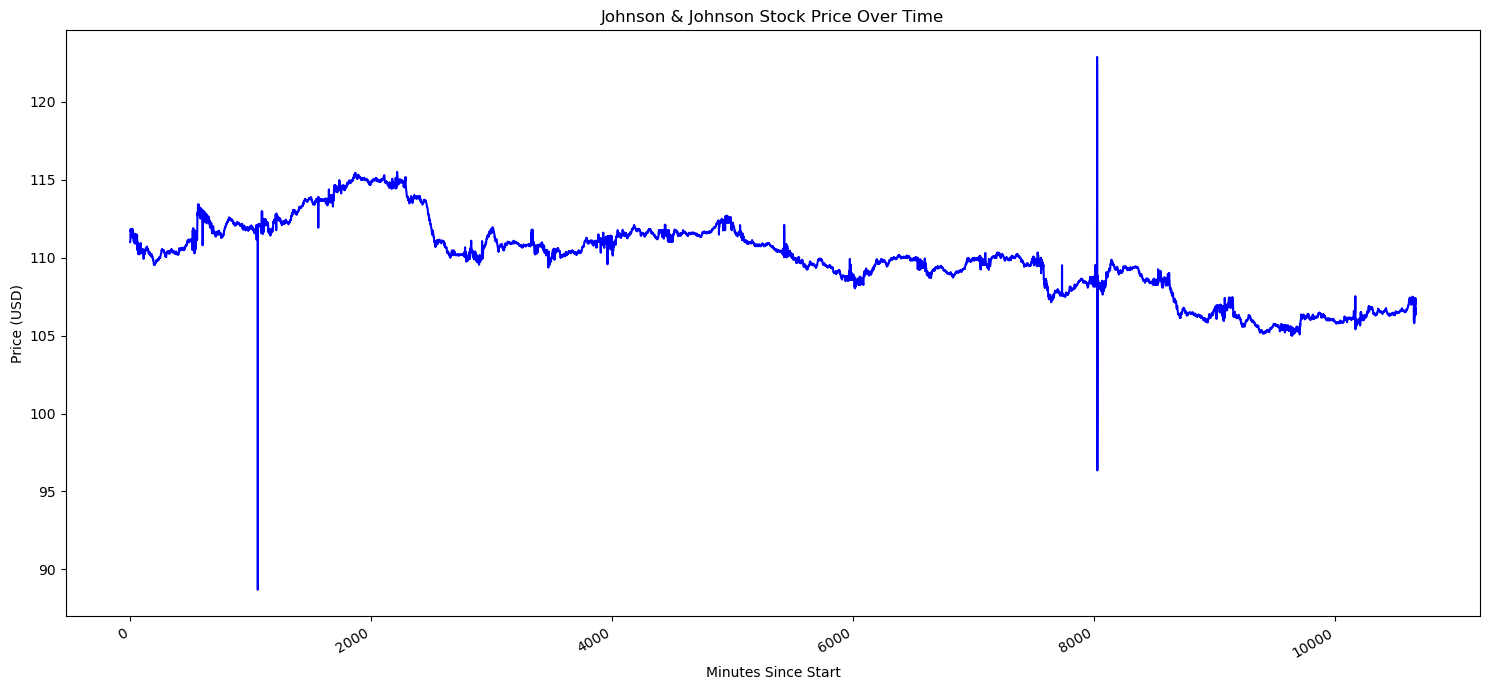

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
jnj = stocks_df_dict['MRK']

# Reset the index to use integers
jnj.reset_index(inplace=True)

#plotting the data
plt.figure(figsize=(15, 7))
plt.plot(jnj.index, jnj['PRICE'], linestyle='-', color='blue')

# Formatting the plot
plt.title('Stock Price Over Time')
plt.xlabel('Minutes Since Start')
plt.ylabel('Price (USD)')
plt.gcf().autofmt_xdate()  # Rotation

# Set the x-ticks to correspond to the dates
# Since there are many dates, we'll show every nth label to avoid clutter

plt.tight_layout()


NOTES FOR NEXT TIME:

- Concatenate the data so it can be fed to the neural network as one big set of training data - a very wide dataset with data on a multitude of stocks
- Develop a good accuracy measure for this larger dataset
- Literature review on what makes a good model - prediction or reaction
- 


Considerations:
Batch Size and Sequence Length: Choosing the right batch size and sequence length is crucial. It might require some experimentation.
Handling Multiple DataFrames: If the data frames represent entirely different sequences (e.g., different stocks), you might consider training separate models for each or redesigning your network to handle multiple sequences.
Feature Engineering: Depending on your data, some feature engineering might be necessary before training.



In [15]:



all_stocks = pd.DataFrame()

print(stocks_df_dict['JNJ'].head())

for stock in stocks_df_dict:
    #create df with one column 'stock'
    stocks_df_dict[stock]['STOCK'] = stock
    #concatenate all stocks
    all_stocks = pd.concat([all_stocks, stocks_df_dict[stock]])

print(all_stocks.head(30))
print(all_stocks.shape)

all_stocks.reset_index(inplace=True)

print(all_stocks.head(30))
#allstocks dimensions
all_stocks.shape

                          PRICE  SIZE stock
DATETIME                                   
2023-01-03 04:00:00  177.099821    56   JNJ
2023-01-03 04:06:00  177.020000     6   JNJ
2023-01-03 04:07:00  177.120000     5   JNJ
2023-01-03 04:16:00  177.650000     8   JNJ
2023-01-03 04:27:00  177.660000     1   JNJ
                          PRICE  SIZE stock STOCK DATETIME
2023-01-03 04:00:00  177.099821    56   JNJ   JNJ      NaT
2023-01-03 04:06:00  177.020000     6   JNJ   JNJ      NaT
2023-01-03 04:07:00  177.120000     5   JNJ   JNJ      NaT
2023-01-03 04:16:00  177.650000     8   JNJ   JNJ      NaT
2023-01-03 04:27:00  177.660000     1   JNJ   JNJ      NaT
2023-01-03 04:28:00  177.640000     2   JNJ   JNJ      NaT
2023-01-03 04:31:00  177.690435    23   JNJ   JNJ      NaT
2023-01-03 04:44:00  177.130000    35   JNJ   JNJ      NaT
2023-01-03 04:51:00  177.750000     1   JNJ   JNJ      NaT
2023-01-03 04:57:00  177.400000     5   JNJ   JNJ      NaT
2023-01-03 05:00:00  177.460000     1   JNJ

(34908, 6)

In [ ]:
combined_df = pd.concat([stocks_df_dict['MRK'], stocks_df_dict['JNJ']] , axis=1)

combined_df.head()

,DATETIME,PRICE,SIZE,level_0,index,DATETIME,PRICE,SIZE
0,2023-01-03 04:00:00,111.519128,195.0,0,0,2023-01-03 04:00:00,177.257958,142
1,2023-01-03 05:00:00,111.766630,92.0,1,1,2023-01-03 05:00:00,177.654968,157
2,2023-01-03 06:00:00,111.366154,195.0,2,2,2023-01-03 06:00:00,177.482639,72
3,2023-01-03 07:00:00,111.121755,997.0,3,3,2023-01-03 07:00:00,176.842483,600
4,2023-01-03 08:00:00,110.771055,7105.0,4,4,2023-01-03 08:00:00,176.673481,2213


In [ ]:
#creating the training and testing data based on 80/20 split
# train = jnj[:int(0.8*(len(jnj)))]
# test = jnj[int(0.8*(len(jnj))):]

jnj.head()

,index,DATETIME,SYM_ROOT,SIZE,PRICE
0,0,2023-01-03 04:00:00.020500736,JNJ,5,177.35
1,1,2023-01-03 04:00:00.969444352,JNJ,3,177.30
2,2,2023-01-03 04:00:01.115286016,JNJ,4,177.35
3,3,2023-01-03 04:00:01.115331328,JNJ,8,177.38
4,4,2023-01-03 04:00:14.855872512,JNJ,13,177.02


In [ ]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout
# from keras.optimizers import Adam
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split

# #convert jnj into a numpy array
# jnj_array = jnj[['PRICE', 'SIZE','DATETIME']].to_numpy()

# #normalize the data
# scaler = MinMaxScaler(feature_range=(0, 1))
# jnj_scaled = scaler.fit_transform(jnj_array.reshape(-1, 1))

# #split the data into training and testing sets
# train, test = train_test_split(jnj_scaled, test_size=0.2)

# train.head()
# test.head()



TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [ ]:
# OPTION 1: LSTM MODEL WITH VOLUME AND MINUTE CLOSING PRICE AS INPUTS

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler



#FUNCTIONAL LTSM MODEL FOR JNJ STOCK DATA - JUST TAKES FOREVER TO RUN
#WAS GOING TO PLAY AROUND WITH INCREASING BATCH SIZE 


# Parameters
look_back = 1200  # Number of time steps to look back for predicting the next step (20 hours)
forward_minutes = 10  # Minutes ahead to predict
batch_size = 64  # Batch size for training

# Load the data
df = jnj

# Normalize the 'PRICE' values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(df['PRICE'].values.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, look_back, forward_minutes):
    X, y = [], []
    for i in range(len(data) - look_back - forward_minutes):
        X.append(data[i:(i + look_back), 0])
        y.append(data[(i + look_back):(i + look_back + forward_minutes), 0])
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(scaled_prices, look_back, forward_minutes)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train_X, test_X = X[0:train_size], X[train_size:len(X)]
train_y, test_y = y[0:train_size], y[train_size:len(y)]

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=50))
model.add(Dense(forward_minutes))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(train_X, train_y, epochs=100, batch_size=batch_size, 
                    validation_data=(test_X, test_y), callbacks=[early_stopping], verbose=1)

# Model summary
model.summary()



Epoch 1/100

   81/25374 [..............................] - ETA: 4:43:01 - loss: 0.0321

KeyboardInterrupt: 